# Librerías

In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn import linear_model

import warnings
warnings.filterwarnings("ignore")

# Dataset

Se hace uso de la base de datos [CO2 Emissions](https://www.kaggle.com/datasets/bhuviranga/co2-emissions) obtenida de la plataforma Kaggle. Se realizará un modelo de regresión lineal, donde la variable *X* hace referencia a las emisiones de CO2 de un modelo de carro y la variable *y* sobre el rendimiento de este en ciudad.

In [2]:
df = pd.DataFrame(pd.read_csv('CO2 Emissions.csv'))[['Fuel Consumption City (L/100 km)','CO2 Emissions(g/km)']]
X = df[['CO2 Emissions(g/km)']]
y = df[['Fuel Consumption City (L/100 km)']]

En total se tienen 7,385 registros, con los siguientes estadísticos:

In [ ]:
df.describe()

,Fuel Consumption City (L/100 km),CO2 Emissions(g/km)
count,7385.000000,7385.000000
mean,12.556534,250.584699
std,3.500274,58.512679
min,4.200000,96.000000
25%,10.100000,208.000000
50%,12.100000,246.000000
75%,14.600000,288.000000
max,30.600000,522.000000


Para realizar la evaluación del modelo se separan los datos, 80% de los datos en entrenamiento y validación y 20% en prueba.
Del 80% dividido en entrenamiento y validación, de primera instancia se hará una separación de 75% y 25% respectivamente

In [3]:
X_sub1, X_test, y_sub1, y_test = train_test_split(X.values, y.values, test_size = 0.2)

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_sub1, y_sub1, test_size = 0.25)

Tamaño de cada subset

In [5]:
print('Entrenamiento:', len(X_train))
print('Validación:', len(X_val))
print('Prueba:', len(X_test))

Entrenamiento: 4431
Validación: 1477
Prueba: 1477


# Modelo regresión lineal

## Entrenamiento

In [6]:
modelo = LinearRegression()
modelo.fit(X = X_train, y = y_train) # entrenamiento con el set de datos correspondientes

LinearRegression()

## Modelo

Como no es regresión multivariada, se tiene la siguiente ecuación que describe al modelo:
$$ y = 0.055x -1.2258$$

In [7]:
print("Intercept:", modelo.intercept_)
print("Coeficiente:", modelo.coef_.flatten())

Intercept: [-1.22579933]
Coeficiente: [0.055004]


## Predicción

In [8]:
y_pred = modelo.predict(X = X_test)

## Grado de sesgo

El sesgo representa el comportamiento de nuestras predicciones comparado con la observación, donde se obtiene el promedio de la diferencia absoluta estandarizada entre estos valores.

Un valor cercano a 1 indica un sesgo alto y uno cercano a 0 un valor bajo. Para un modelo con mayor exactitud se recomienda tener menores niveles de sesgo.

Como podemos observar, nuestras predicciones tienen un coeficiente muy bajo, lo que nos indica que nuestros datos no presentan sesgo.



In [19]:
np.mean(abs((y_pred - y_test)/y_test))

0.04611987382645892

## Nivel de ajuste

Para analizar si hay overfitting o underfitting se necesitan obtener las métricas para los sets de entrenamiento, validación y prueba.

In [46]:
# Predicciones para distintos sets
y_pred_train = modelo.predict(X = X_train)
y_pred_val = modelo.predict(X = X_val)

In [29]:
# Error cuadrático medio para distintos sets
rmse_train = mean_squared_error(
        y_true  = y_train,
        y_pred  = y_pred_train,
        squared = False
       )

rmse_val = mean_squared_error(
        y_true  = y_val,
        y_pred  = y_pred_val,
        squared = False
       )

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

Como podemos observar, en los 3 sets se comporta de manera similar en cuanto a las evaluaciones y no hay diferencias significativas en estos, por lo que podemos decir que no se presenta overfitting o underfitting.

In [30]:
# Resultados
resultados = pd.DataFrame({'R^2':[modelo.score(X_train, y_train), modelo.score(X_val, y_val), modelo.score(X_test, y_test)],
'RMSE':[rmse_train, rmse_val, rmse]}, index = ['Train','Val','Test'])
resultados

,R^2,RMSE
Train,0.839105,1.385066
Val,0.840850,1.405483
Test,0.864904,4.737630


## Grado de varianza

Se quiere observar la sensibilidad de nuestro modelo con distintos porcentajes de separación, es por esto, que en esta sección se entrenarán diversos modelos y se graficarán sus errores y coeficientes de determinación para obtener el mejor valor del %.

In [31]:
# Primera separación
X_sub1, X_test, y_sub1, y_test = train_test_split(X.values, y.values, test_size = 0.2)

# Separaciones del 10% al 91% en pasos de 5%
split = np.arange(0.1, 0.91, 0.05)
RMSE, r2= list(), list()
for i in split:
  X_train, X_val, y_train, y_val = train_test_split(X_sub1, y_sub1, test_size = i)
  # Modelo
  modelo = LinearRegression()
  modelo.fit(X = X_train, y = y_train)

  # Predicciones
  # Predicciones para distintos sets
  y_pred_train = modelo.predict(X = X_train)
  y_pred_val = modelo.predict(X = X_val)

  # RMSE
  rmse_train = mean_squared_error(
          y_true  = y_train,
          y_pred  = y_pred_train,
          squared = False
        )

  rmse_val = mean_squared_error(
          y_true  = y_val,
          y_pred  = y_pred_val,
          squared = False
        )
  # Métricas de evaluación del modelo
  RMSE.append([rmse_train, rmse_val])
  r2.append([modelo.score(X_train, y_train), modelo.score(X_val, y_val)])

RMSE = pd.DataFrame(RMSE, columns = ['Train','Val'], index = split)
r2 = pd.DataFrame(r2, columns = ['Train','Val'], index = split)

RMSE['Dif'] = RMSE.Train-RMSE.Val
r2['Dif'] = abs(r2.Train-r2.Val)

### RMSE

Ya que es un error, se desean valores más pequeños y con una diferencia no tan grande entre los sets para descartar overfitting o underfitting.

En el caso que el RMSE de validación esté muy por encima del de traininig, significa un posible underfitting, ya que el modelo predice bien con los valores de entrenamiento pero al ingresarles nuevos valores, este no es tan acertivo.

Por otro lado, si el training set está muy por encima del validation set, sinifica un posible overfitting, ya que el modelo se sobreajusta a los valores de entrenamiento pero no a nuevos valores.

En este caso, se quiere una diferencia no tan significativa entre ambos conjuntos de datos. Preferiblemente donde el set de validación esté por encima del training set.

<Axes: title={'center': 'RMSE for training and validation set'}>

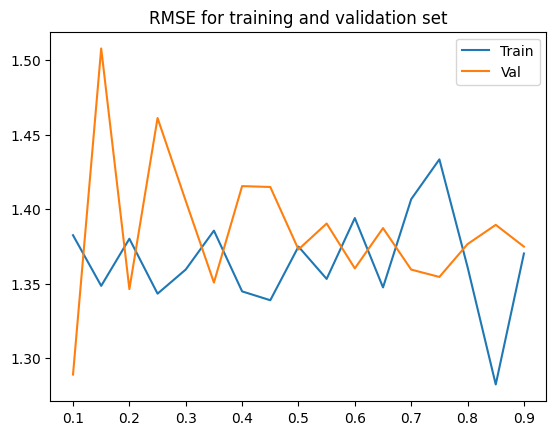

In [32]:
RMSE.drop('Dif', axis = 1).plot(title = 'RMSE for training and validation set')

En la gráfica de diferencia de errores de los sets, se aprecia que los valores positivos es donde el training set tuvo un mayor error que el de validaton. En este caso, debido a que se trata de un error, se busca un punto donde el set de validación tenga un mayor valor que el de training (diferencias negativas) y un menor error que el primer modelo de este documento.

Además observamos que nuestro modelo es sensible a este parámetro, ya que puede pasar de una diferencia negativa a una positiva en cuestión de pocas iteraciones, por lo que se dice que hay variabilidad.

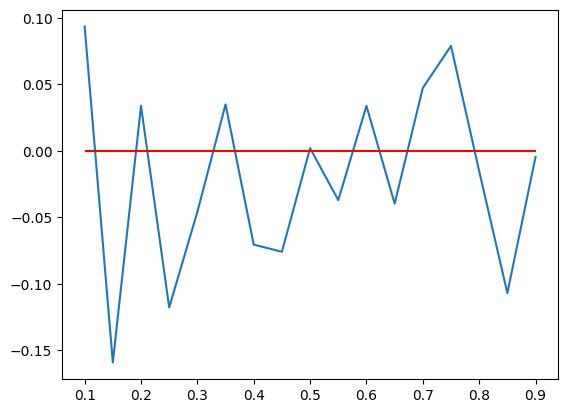

In [33]:
plt.plot(RMSE.Dif)
plt.hlines(0, xmin = split[0], xmax = split[-1], color = 'red')

In [34]:
RMSE_split = RMSE[(RMSE.Dif <= 0) & (RMSE.Train <= resultados.RMSE.Train) & (RMSE.Val <= resultados.RMSE.Val)]
RMSE_split

,Train,Val,Dif
0.55,1.353230,1.390397,-0.037167
0.65,1.347524,1.387320,-0.039795
0.80,1.361195,1.376592,-0.015397
0.85,1.282405,1.389500,-0.107095
0.90,1.370283,1.374892,-0.004609


### R^2

En este caso, a diferencia del error, se desean valores más altos, igual con una diferencia no tan grande entre los sets para descartar overfitting o underfitting.

En el caso que el training set esté muy por encima del validation set, significa un posible overfitting, donde nuestro modelo funciona muy bien con los datos conocidos pero con los nuevos no predice bien. En el caso contrario,

En este caso, se quiere una diferencia no tan significativa entre ambos conjuntos de datos. Como la ubicación del training set respecto al validation set no es de tanta importancia como en el caso de RMSE, se considera la diferencia absoluta entre sus coeficientes.

<Axes: title={'center': 'RMSE for training and validation set'}>

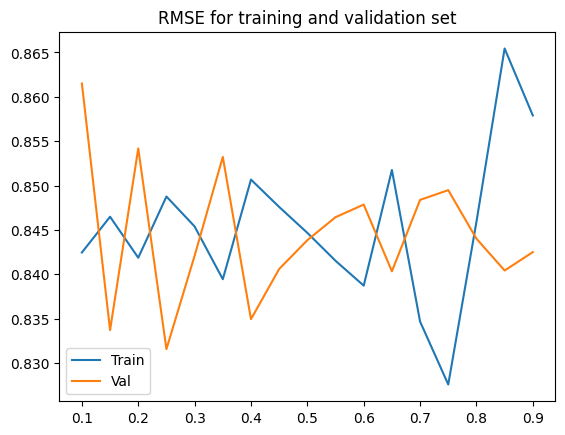

In [35]:
r2.drop('Dif', axis = 1).plot(title = 'RMSE for training and validation set')

Observamos que la diferencia entre nuestros sets disminuye drásticamente entre en los primeros porcentajes, y no se observa alguna tendencia. Y al igual que el error RMSE, se observa una gran variabilidad, ya que en varias ocasiones se observa que se alcanza una diferencia elevada y en la siguiente iteración se presenta una mínima.

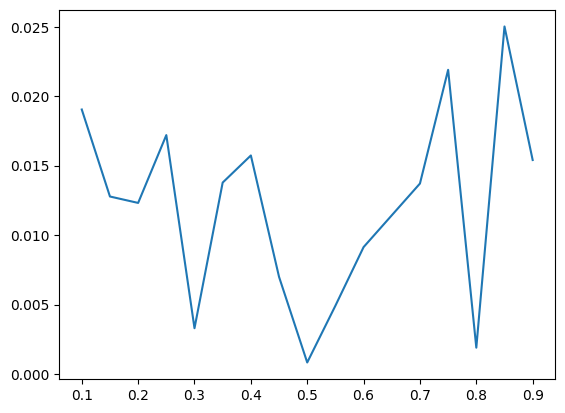

In [36]:
plt.plot(r2.Dif)

Se desea encontrar un % de separación que obtenga coeficientes mayores que en el primer modelo de nuestro proyecto y con una diferencia no significativa:

In [37]:
R2_split = r2[(r2.Train >= resultados['R^2'].Train) & (r2.Val >= resultados['R^2'].Val)]
R2_split

,Train,Val,Dif
0.10,0.842461,0.861503,0.019042
0.20,0.841871,0.854186,0.012315
0.30,0.845393,0.842100,0.003293
0.35,0.839449,0.853230,0.013781
0.50,0.844674,0.843849,0.000825
0.55,0.841525,0.846438,0.004913
0.80,0.845910,0.844019,0.001891
0.90,0.857907,0.842502,0.015405


### Selección

De nuestro análisis de ambas métricas obtenemos que los % de separación mejoran el R^2 o el RMSE, según sea el caso. Y los valores que aparecen en ambas mejoras son los: 85% y 90%. Los cuales tienen las siguientes métricas:

In [41]:
# Error cuadrático medio
RMSE_split.iloc[[2,4]]

,Train,Val,Dif
0.8,1.361195,1.376592,-0.015397
0.9,1.370283,1.374892,-0.004609


In [43]:
# Coeficiente de determinación
R2_split.iloc[[6,7]]

,Train,Val,Dif
0.8,0.845910,0.844019,0.001891
0.9,0.857907,0.842502,0.015405


Sus valores son muy similares, por lo que se decide escoger una separación del 80%, debido a que en promedio, en ambas métricas tiene menor diferencia. Esto significaría una distribución del 20% para el set de entrenamiento y 80% para el de validación.

Por otro lado, se puede decir que los modelos tienen una varianza media-alta debido a su variabilidad a través de distintos porcentajes de separación.

### Modelo final

20% para datos de entrenamiento y 80% en validación.

In [65]:
X_train, X_val, y_train, y_val = train_test_split(X_sub1, y_sub1, test_size = 0.80)

# Modelo
modelo = LinearRegression()
modelo.fit(X = X_train, y = y_train)

# Predicciones
y_pred_val = modelo.predict(X = X_val)
y_pred = modelo.predict(X = X_test)

In [66]:
# RMSE
rmse_test = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
      )

rmse_val = mean_squared_error(
        y_true  = y_val,
        y_pred  = y_pred_val,
        squared = False
        )

Observamos que para el set de prueba el RMSE se eleva mucho.

In [67]:
print('Error cuadrático medio')
print('Validation:', round(rmse_val,2))
print('Test:', round(rmse_test,2))
print('--------------------------------')
print('Coeficiente determinación')
print('Validation:', round(modelo.score(X_val, y_val),2))
print('Test:', round(modelo.score(X_test, y_test),2))

Error cuadrático medio
Validation: 1.38
Test: 1.38
--------------------------------
Coeficiente determinación
Validation: 0.84
Test: 0.85


**Gráficas**


En las siguientes gráficas podemos observar el ajuste de nuestra recta con los datos, donde el color claro representan las observaciones y los más oscuros las predicciones.

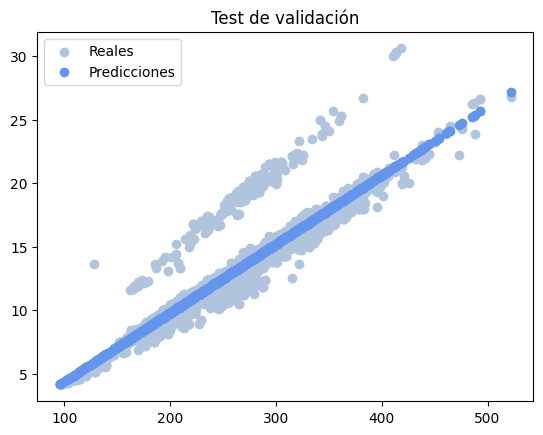

In [68]:
plt.scatter(X_val,y_val, color = 'lightsteelblue')
plt.scatter(X_val,y_pred_val, color = 'cornflowerblue')
plt.title('Test de validación')
plt.legend(['Reales','Predicciones'])

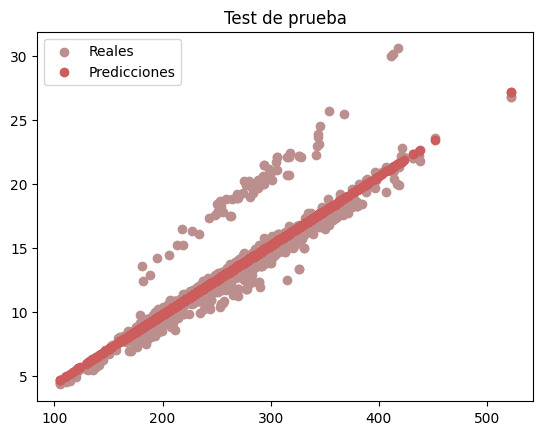

In [69]:
plt.scatter(X_test,y_test, color = 'rosybrown')
plt.scatter(X_test,y_pred, color = 'indianred')
plt.title('Test de prueba')
plt.legend(['Reales','Predicciones'])

Se quiere observar la sensibilidad de nuestro modelo con distintos porcentajes de separación de datos.

# Técnicas de regularización

Para este apartado se usa el modelo SGD de la librería sklearn y se observa su comportamiento con distintos parámetros de penalización (l2, l1, elasticnet, None).
Entre sus parámetros default se incluye la pérdida *Hinge*, la cual da un SVM lineal.

In [81]:
# array para las métricas con regularización
reg = {}

**Penalización l2**

In [82]:
# Always scale the input. The most convenient way is to use a pipeline.
l2 = linear_model.SGDClassifier(penalty = 'l2')
l2.fit(X_train, y_train.astype('int'))
reg['l2'] = [round(mean_squared_error(y_val, l2.predict(X_val), squared = False),2),
             round(l2.score(X_val, y_val.astype('int')),2)]

**Penalización l1**

In [83]:
# Always scale the input. The most convenient way is to use a pipeline.
l1 = linear_model.SGDClassifier(penalty = 'l1')
l1.fit(X_train, y_train.astype('int'))
reg['l1'] = [round(mean_squared_error(y_val, l1.predict(X_val), squared = False),2),
             round(l1.score(X_val, y_val.astype('int')),2)]

**Penalización elasticnet**

In [84]:
# Always scale the input. The most convenient way is to use a pipeline.
ela = linear_model.SGDClassifier(penalty = 'elasticnet')
ela.fit(X_train, y_train.astype('int'))
reg['elasticnet'] = [round(mean_squared_error(y_val, ela.predict(X_val), squared = False),2),
             round(ela.score(X_val, y_val.astype('int')),2)]

**Penalización None**

In [85]:
# Always scale the input. The most convenient way is to use a pipeline.
none = linear_model.SGDClassifier(penalty = None)
none.fit(X_train, y_train.astype('int'))
reg['None'] = [round(mean_squared_error(y_val, none.predict(X_val), squared = False),2),
             round(none.score(X_val, y_val.astype('int')),2)]

### Resultados

Se obtienen los scores del error RSME y el promedio de presición de los mdoelos con distintos parámetros de penalización. Podemos observar que ninguno de estos es aceptable, sin embargo, los parámetors l2 y l1 son los que mejores resultados dieron.

In [87]:
pd.DataFrame(reg, index = ['RSME','Mean accuracy'])

,l2,l1,elasticnet,None
RSME,3.83,3.83,4.99,6.58
Mean accuracy,0.13,0.13,0.10,0.03
